# Topology of time series

This notebook explores how `giotto-tda` can be used to gain insights from time-varying data by using ideas from from dynamical systems and persistent homology.

If you are looking at a static version of this notebook and would like to run its contents, head over to [GitHub](https://github.com/giotto-ai/giotto-tda/blob/master/examples/topological_timeseries.ipynb) and download the source.

## Useful references

* [Topological Methods for the Analysis of Data](https://youtu.be/DZwK2gT-d8g) by Jose Perea
* The sliding window notebooks from Chris Tralie's [TDALabs](https://github.com/ctralie/TDALabs)
* [_Detection of gravitational waves using topological data analysis and convolutional
neural network: An improved approach_](https://arxiv.org/pdf/1910.08245.pdf) by Christopher Bresten and Jae-Hun Jung. We thank Christopher Bresten for sharing the code and data used in the article.

## From time series to time delay embeddings

The first step in analysing the topology of time series is to construct a _**time delay embedding**_ or _**Takens embedding**_, named after [Floris Takens](https://en.wikipedia.org/wiki/Floris_Takens) who pioneered its use in the study of [dynamical systems](https://en.wikipedia.org/wiki/Takens's_theorem). A time delay embedding can be thought of as sliding a "window" of fixed size over a signal, with each window represented as a point in a (possibly) higher-dimensional space. A simple example is shown in the animation below, where pairs of points in a 1-dimensional signal are mapped to coordinates in a 2-dimensional embedding space. 

![](time-delay-embedding.gif)

More formally, given a time series $f(t)$, one can extract a _**sequence of vectors**_ of the form $f_i = [f(t_i), f(t_i + 2 \tau), \ldots, f(t_i + (d-1) \tau)] \in \mathbb{R}^{d}$, where $d$ is the _**embedding dimension**_ and $\tau$ is the _**time delay**_. The quantity $(d-1)\tau$ is known as the "window size" and the difference between $t_{i+1}$ and $t_i$ is called the **_stride_**. In other words, the time delay embedding of $f$ with parameters $(d,\tau)$ is the function

$$
TD_{d,\tau} f : \mathbb{R} \to \mathbb{R}^{d}\,, \qquad t \to \begin{bmatrix}
           f(t) \\
           f(t + \tau) \\
           f(t + 2\tau) \\
           \vdots \\
           f(t + (d-1)\tau)
         \end{bmatrix}
$$


and the main idea we will explore in this notebook is that if $f$ has a non-trivial recurrent structure, then the image of $TD_{d,\tau}f$ will have non-trivial topology for appropriate choices of $(d, \tau)$.

## A periodic example

As a warm-up, recall that a function is periodic with period $T > 0$ if $f(t + T) = f(t)$ for all $t \in \mathbb{R}$. For example, consider the function $f(t) = \cos(5 t)$ which can be visualised as follows:

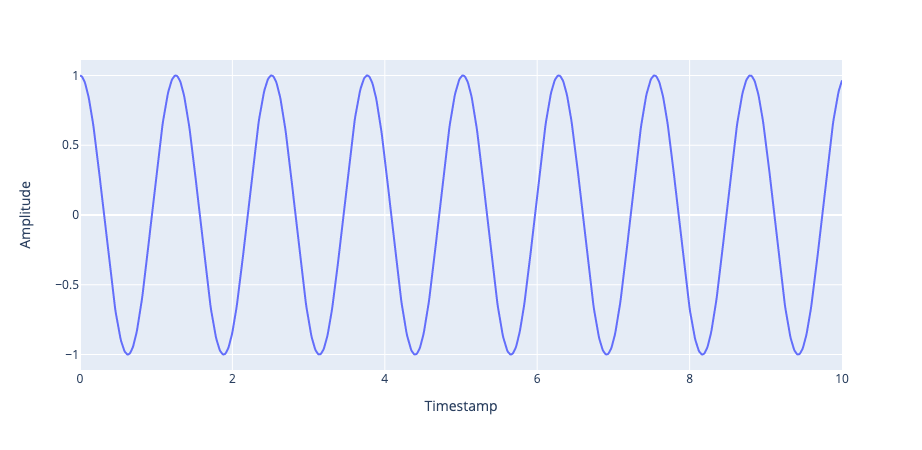

In [1]:
import numpy as np
import plotly.express as px

x_periodic = np.linspace(0, 10, 1000)
y_periodic = np.cos(5 * x_periodic)

px.line(x=x_periodic, y=y_periodic, labels={"x": "Timestamp", "y": "Amplitude"})

We can show that periodicity implies ellipticity of the time delay embedding. To do that we need to specify the embedding dimension $d$ and the time delay $\tau$ for the Takens embedding, which in `giotto-tda` can be achieved as follows:

In [2]:
from gtda.time_series import TakensEmbedding

embedding_dimension_periodic = 3
embedding_time_delay_periodic = 8
stride = 10

embedder_periodic = TakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_periodic,
    dimension=embedding_dimension_periodic,
    stride=stride,
)

**Tip:** You can use the `stride` parameter to downsample the time delay embedding. This is handy when you want to quickly compute persistence diagrams on a dense signal.

Let's apply this embedding to our time series to get a _new_ time series:

In [3]:
y_periodic_embedded = embedder_periodic.fit_transform(y_periodic)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

Shape of embedded time series: (99, 3)


We have gone from a one-dimensional series to a 3-dimensional one, so let's visualise the time delay embedding as a point cloud:

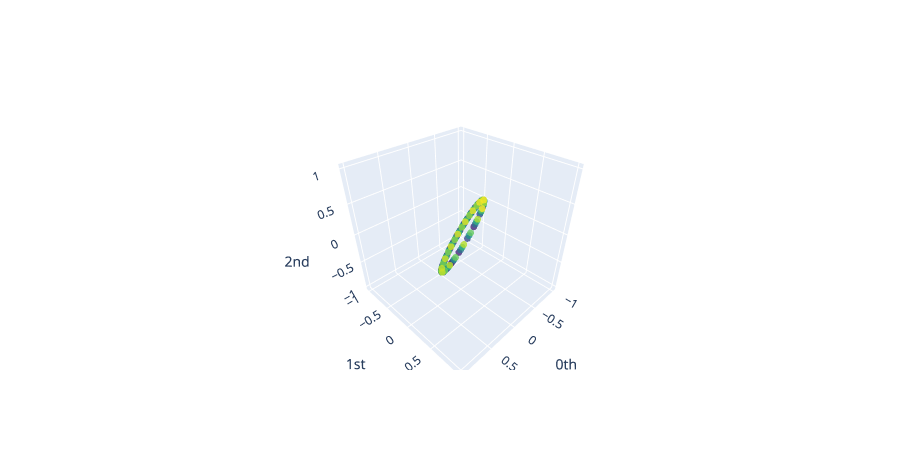

In [4]:
from gtda.plotting import plot_point_cloud

plot_point_cloud(y_periodic_embedded)

As promised, the periodicity of $f$ is reflected in the ellipticity of the time delay embedding! It turns out that in general, _**periodic functions trace out ellipses**_ in $\mathbb{R}^{d}$. 

## A non-periodic example

Here is another type of recurrent behaviour: if we let $f(t) = \cos(t) + \cos(\pi t)$ then it follows that $f$ is not periodic since the ratio of the two frequencies is irrational, i.e. we say that $\cos(t)$ and $\cos(\pi t)$ are _incommensurate_. Nevertheless, their sum produces recurrent behaviour:

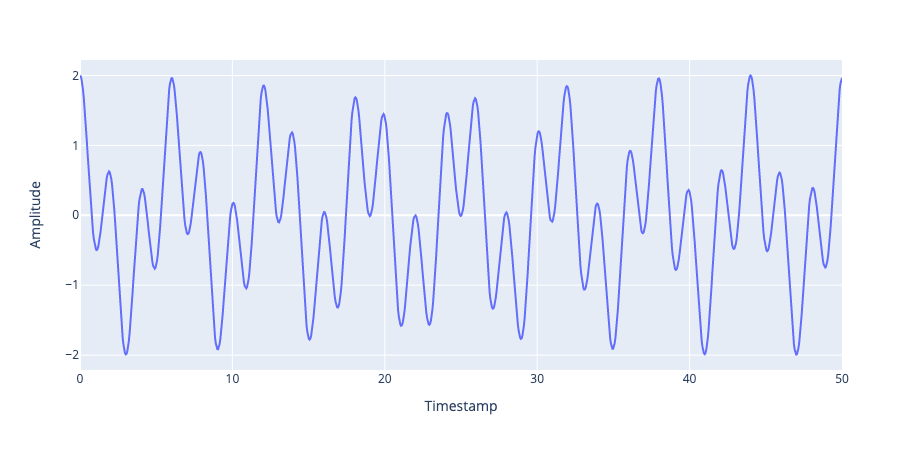

In [5]:
x_nonperiodic = np.linspace(0, 50, 1000)
y_nonperiodic = np.cos(x_nonperiodic) + np.cos(np.pi * x_nonperiodic)

px.line(x=x_nonperiodic, y=y_nonperiodic, labels={"x": "Timestamp", "y": "Amplitude"})

As before, let's create a time delay embedding for this signal and visualise the resulting point cloud:

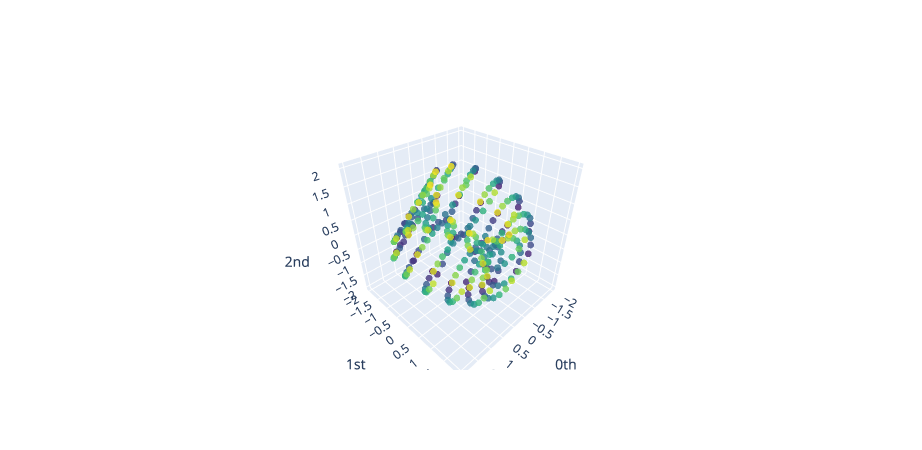

In [6]:
embedding_dimension_nonperiodic = 3
embedding_time_delay_nonperiodic = 16
stride = 3

embedder_nonperiodic = TakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay_nonperiodic,
    dimension=embedding_dimension_nonperiodic,
    stride=stride,
)

y_nonperiodic_embedded = embedder_nonperiodic.fit_transform(y_nonperiodic)

plot_point_cloud(y_nonperiodic_embedded)

## From time delay embeddings to persistence diagrams

In the examples above we saw that the resulting point clouds appear to exhibit distinct topology. We can verify this explicitly using persistent homology! First we need to reshape our point cloud arrays in a form suitable for the [`VietorisRipsPersistence` transformer](https://giotto-ai.github.io/gtda-docs/latest/notebooks/vietoris_rips_quickstart.html), namely `(n_samples, n_points, n_dimensions)`:

In [7]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

The next step is to calculate the persistence diagrams associated with each point cloud. In `giotto-tda` we can do this with the Vietoris-Rips construction as follows:

Persistence diagram for periodic signal


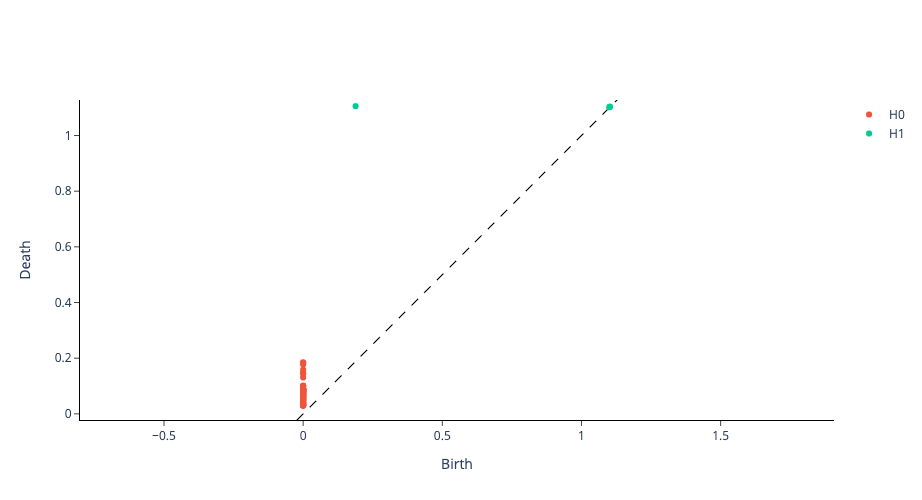

Persistence diagram for nonperiodic signal


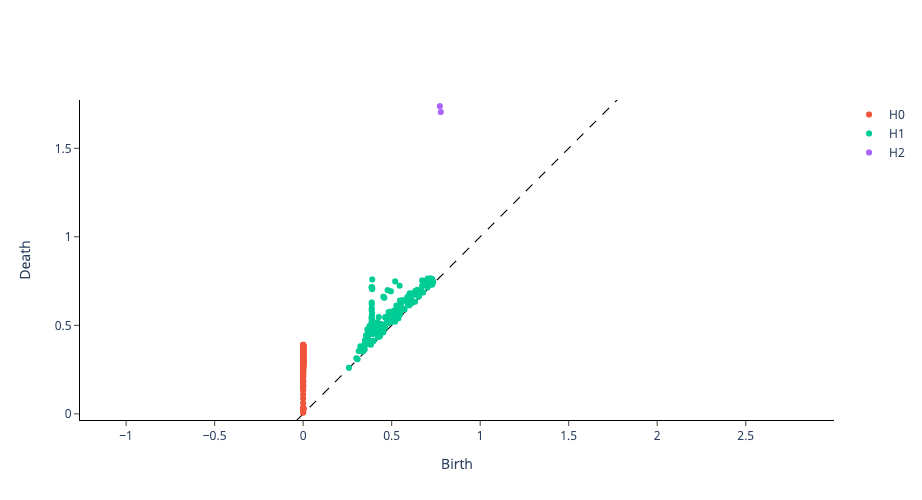

In [8]:
from gtda.homology import VietorisRipsPersistence

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for periodic signal")
periodic_persistence.fit_transform_plot(y_periodic_embedded)

nonperiodic_persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=6
)
print("Persistence diagram for nonperiodic signal")
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded);

What can we conclude from these diagrams? The first thing that stands out is the different types of homology dimensions that are most persistent. In the periodic case we see a single point associated with 1-dimensional persistent homology, namely a loop! On the other hand, the non-periodic signal has revealed two points associated with 2-dimensional persistent homology, namely _voids_. These clear differences in topology make the time delay embedding technique especially powerful at classifying different time series.

## Picking the embedding dimension and time delay

In the examples above, we manually chose values for the embedding dimension $d$ and time delay $\tau$. However, it turns out there are two techniques that can be used to determine these parameters _automatically_:

* [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) to determine $\tau$
* [False nearest neighbours](https://en.wikipedia.org/wiki/False_nearest_neighbor_algorithm) to determine $d$

In `giotto-tda`, these techniques are applied when we select `parameters_type="search"` in the `TakensEmbedding` transformer, e.g.

```python
embedder = TakensEmbedding(
    parameters_type="search", time_delay=time_delay, dimension=embedding_dimension,
)
```

where the values of `time_delay` and `embedding_dimension` provide _**upper bounds**_ on the search algorithm. Before applying this to our sample signals, let's have a look at how these methods actually work under the hood.

### Mutual information
To determine an optimal value for $\tau$ we first calculate the maximum $x_\mathrm{max}$ and minimum $x_\mathrm{min}$ values of the time series, and divide the interval $[x_\mathrm{min}, x_\mathrm{max}]$ into a large number of bins. We let $p_k$ be the probability that an element of the time series is in the $k$th bin and let $p_{j,k}$ be the probability that $x_i$ is in the $j$th bin while $x_{i+\tau}$ is in the $k$th bin. Then the mutual information is defined as:

$$ I(\tau) = - \sum_{j=1}^{n_\mathrm{bins}} \sum_{k=1}^{n_\mathrm{bins}} p_{j,k}(\tau) \log \frac{p_{j,k}(\tau)}{p_j p_k} $$

The first minimum of $I(\tau)$ gives the optimal time delay since there we get the most information by adding $x_{i+\tau}$.

### False nearest neighbours

The false nearest neighbours algorithm is based on the assumption that "unfolding" or embedding a deterministic system into successively higher dimensions is smooth. In other words, points which are close in one embedding dimension should be close in a higher one. More formally, if we have a point $p_i$ and neighbour $p_j$, we check if the normalised distance $R_i$ for the next dimension is greater than some threshold $R_\mathrm{th}$:

$$ R_i = \frac{\mid x_{i+m\tau} - x_{j+m\tau} \mid}{\lVert p_i - p_j \rVert} > R_\mathrm{th}$$

If $R_i > R_\mathrm{th}$ then we have a "false nearest neighbour" and the optimal embedding dimension is obtained by minimising the total number of such neighbours.

### Running the search algorithm

Let's now apply these ideas to our original signals to see what the algorithm determines as optimal choices for $d$ and $\tau$. We will allow the search to scan up to relatively large values of $(d, \tau)$ to ensure we do not get stuck in a sub-optimal minimum.

For the periodic signal, we initialise the Takens embedding as follows:

In [9]:
max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder_periodic = TakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

Let's create a helper function to view the optimal values found during the search:

In [10]:
def fit_embedder(embedder: TakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

In [11]:
y_periodic_embedded = fit_embedder(embedder_periodic, y_periodic)

Shape of embedded time series: (171, 6)
Optimal embedding dimension is 6 and time delay is 29


Although the resulting embedding is in a high dimensional space, we can apply dimensionality reduction techniques like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project down to 3-dimensions for visualisation:

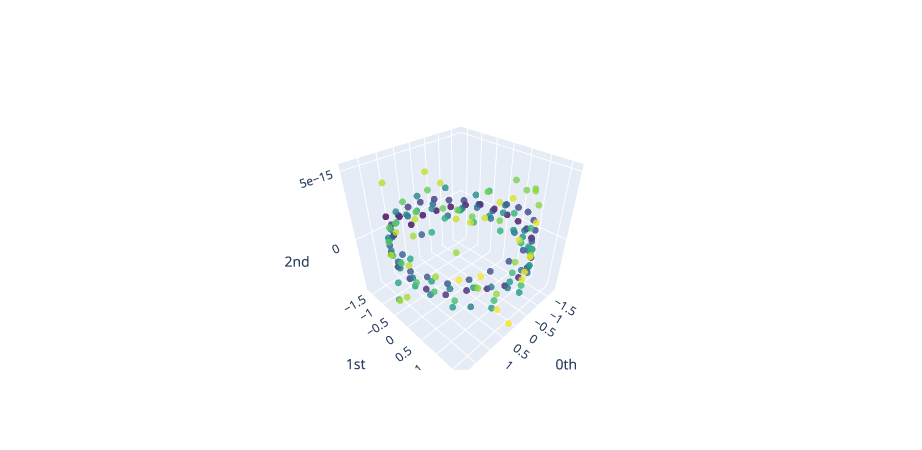

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Now for the non-periodic case we have:

In [13]:
embedder_nonperiodic = TakensEmbedding(
    parameters_type="search", n_jobs=2, time_delay=max_time_delay, dimension=max_embedding_dimension, stride=stride,
)

y_nonperiodic_embedded = fit_embedder(embedder_nonperiodic, y_nonperiodic)

Shape of embedded time series: (186, 6)
Optimal embedding dimension is 6 and time delay is 14


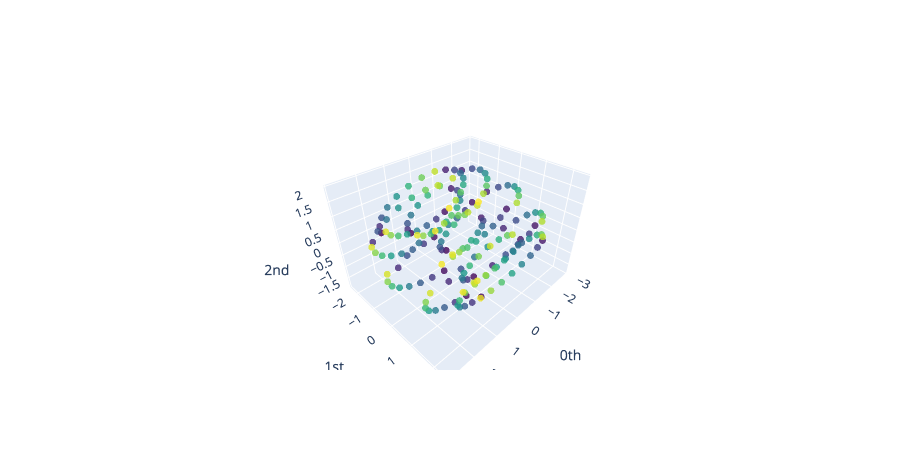

In [14]:
pca = PCA(n_components=3)
y_nonperiodic_embedded_pca = pca.fit_transform(y_nonperiodic_embedded)
plot_point_cloud(y_nonperiodic_embedded_pca)

So we have embedding point clouds whose geometry looks clearly distinct; how about the persistence diagrams? As we did earlier, we first need to reshape our arrays into the form `(n_samples, n_points, n_dimensions)`:

In [15]:
y_periodic_embedded = y_periodic_embedded[None, :, :]
y_nonperiodic_embedded = y_nonperiodic_embedded[None, :, :]

The next step is to calculate the persistence diagrams associated with each point cloud:

Persistence diagram for periodic signal


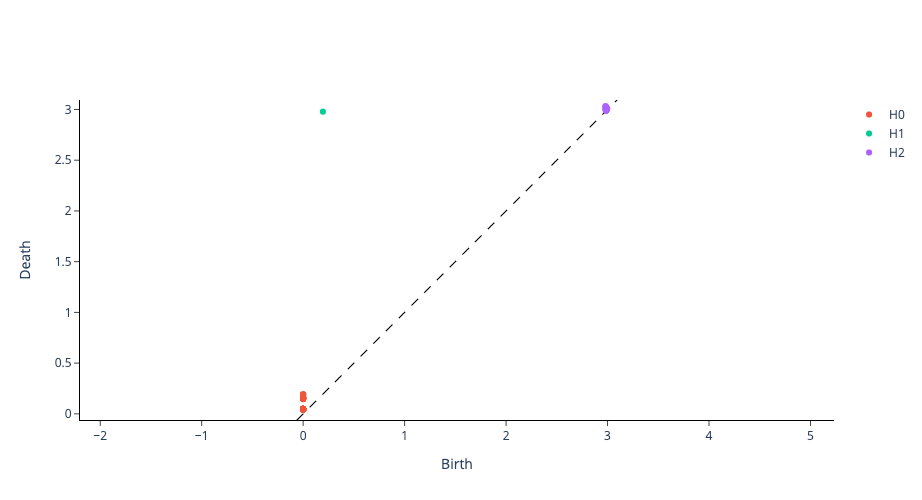

Persistence diagram for nonperiodic signal


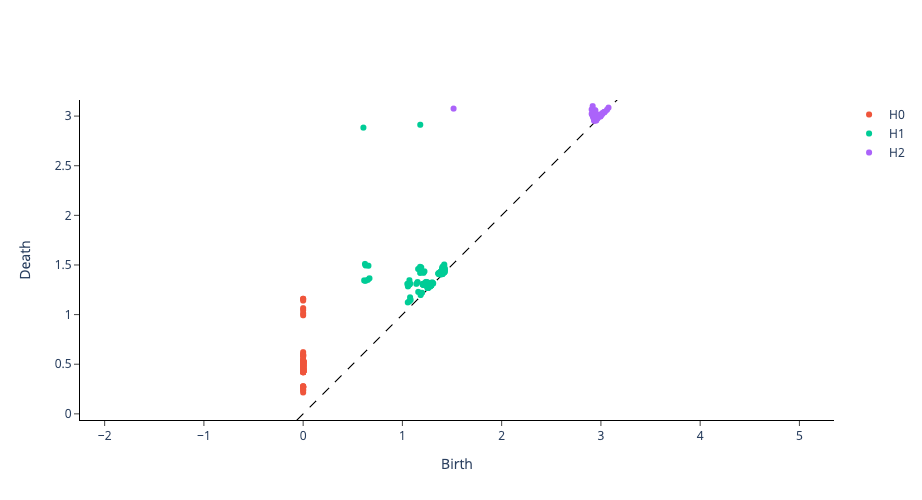

In [16]:
homology_dimensions = [0, 1, 2]

periodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
print('Persistence diagram for periodic signal')
periodic_persistence.fit_transform_plot(y_periodic_embedded);

nonperiodic_persistence = VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6)
print('Persistence diagram for nonperiodic signal')
nonperiodic_persistence.fit_transform_plot(y_nonperiodic_embedded);

In this case the persistence diagram for the periodic signal is essentially unchanged, but the non-periodic signal now reveals two $H_1$ points and one $H_2$ one - the signature of a hypertorus! It turns out that in general, the image of $TD_{d,\tau}f$ is a hypertorus.

## Gravitational wave detection
As an application of the above ideas, let's examine how persistent homology can help detect gravitational waves in noisy signals. The following is adapted from the article by Chrisopher Bresten and Jae-Hun Jung. As shown in the videos below, we will aim to pick out the "chirp" signal of two colliding black holes from a very noisy backgound.

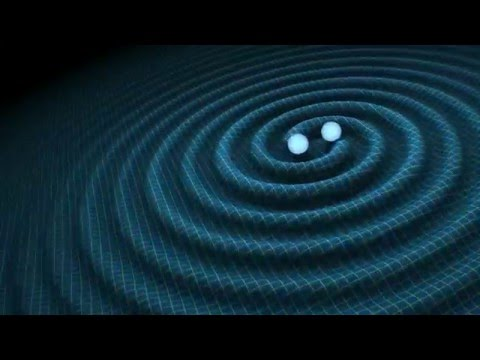

In [17]:
from IPython.display import YouTubeVideo

YouTubeVideo("Y3eR49ogsF0", width=600, height=400)

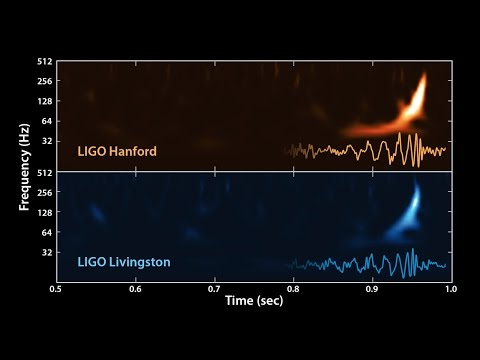

In [18]:
YouTubeVideo("QyDcTbR-kEA", width=600, height=400)

### Generate the data

In the article, the authors create a synthetic training set as follows: 

* Generate gravitational wave signals that correspond to non-spinning binary black hole mergers
* Generate a noisy time series and embed a gravitational wave signal with probability 0.5 at a random time.

The result is a set of time series of the form

$$ s = g + \epsilon \frac{1}{R}\xi $$

where $g$ is a gravitational wave signal from the reference set, $\xi$ is Gaussian noise, $\epsilon=10^{-19}$ scales the noise amplitude to the signal, and $R \in (0.075, 0.65)$ is a parameter that controls the signal-to-noise-ratio (SNR).

### Constant signal-to-noise ratio

As a warmup, let's generate some noisy signals with a constant SNR of 17.98. As shown in Table 1 of the article, this corresponds to an $R$ value of 0.65. By picking the upper end of the interval, we can gain a sense for what the best possible performance is for our time series clasifier. We pick a small number of samples to make the computations run fast, but in practice would scale this by 1-2 orders of magnitude as done in the original article.

In [19]:
from datasets import make_gravitational_waves
from pathlib import Path

R = 0.65
n_signals = 100
DATA = Path("./")

noisy_signals, gw_signals, labels = make_gravitational_waves(
    path_to_data=DATA, n_signals=n_signals, r_min=R, r_max=R, n_snr_values=1
)

print(f"Number of noisy signals: {len(noisy_signals)}")
print(f"Number of timesteps per series: {len(noisy_signals[0])}")

Number of noisy signals: 100
Number of timesteps per series: 8692


Next let's visualise the two different types of time series that we wish to classify: one that is pure noise vs. one that is composed of noise plus an embedded gravitational wave signal:

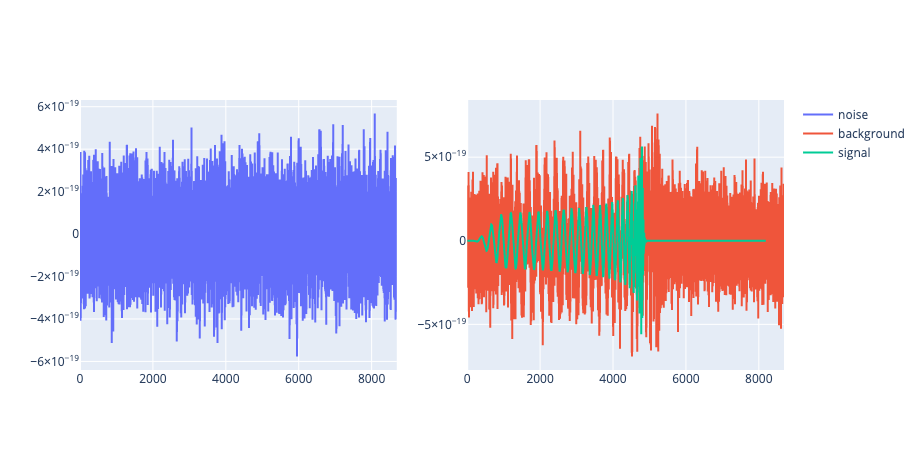

In [20]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# get the index corresponding to the first pure noise time series
background_idx = np.argmin(labels)
# get the index corresponding to the first noise + gravitational wave time series
signal_idx = np.argmax(labels)

ts_noise = noisy_signals[background_idx]
ts_background = noisy_signals[signal_idx]
ts_signal = gw_signals[signal_idx]

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_noise))), y=ts_noise, mode="lines", name="noise"),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(ts_background))),
        y=ts_background,
        mode="lines",
        name="background",
    ),
    row=1,
    col=2,
)

fig.add_trace(
    go.Scatter(x=list(range(len(ts_signal))), y=ts_signal, mode="lines", name="signal"),
    row=1,
    col=2,
)
fig.show()

Let's examine what the time delay embedding of a pure gravitational wave signal looks like:

In [21]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = TakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_gw_embedded = fit_embedder(embedder, gw_signals[0])

Shape of embedded time series: (1529, 20)
Optimal embedding dimension is 20 and time delay is 29


As we did in our simple examples, we can use PCA to project our high-dimensional space to 3-dimensions for visualisation:

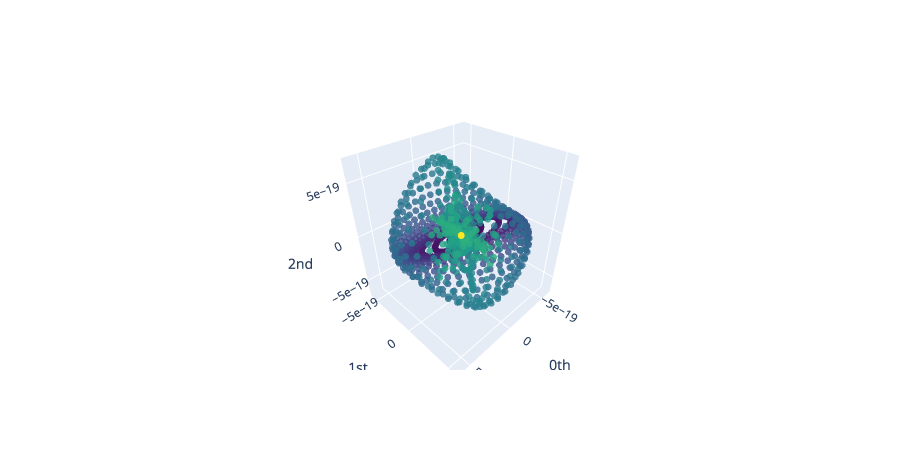

In [22]:
pca = PCA(n_components=3)
y_gw_embedded_pca = pca.fit_transform(y_gw_embedded)

plot_point_cloud(y_gw_embedded_pca)

From the plot we can see that the decaying periodic signal generated by a black hole merger emerges as a _spiral_ in the time delay embedding space! For contrast, let's compare this to one of the pure noise time series in our sample:

Shape of embedded time series: (1719, 8)
Optimal embedding dimension is 8 and time delay is 14


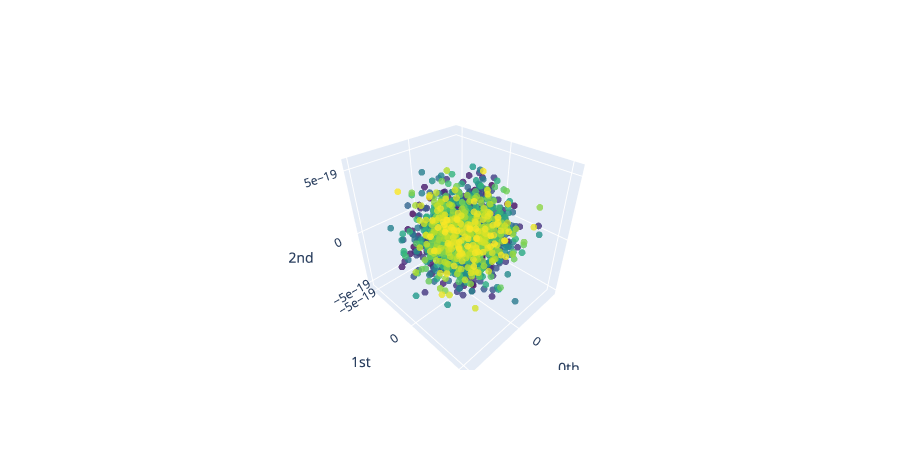

In [23]:
embedding_dimension = 30
embedding_time_delay = 30
stride = 5

embedder = TakensEmbedding(
    parameters_type="search", n_jobs=6, time_delay=embedding_time_delay, dimension=embedding_dimension, stride=stride
)

y_noise_embedded = fit_embedder(embedder, noisy_signals[background_idx])

pca = PCA(n_components=3)
y_noise_embedded_pca = pca.fit_transform(y_noise_embedded)

plot_point_cloud(y_noise_embedded_pca)

Evidently pure noise resembles a high-dimensional ball in the time delay embedding space. Let's see if we can use persistent homology to tease apart which time series contain a gravitational wave signal versus those that don't. To do so we will adapt the strategy from the original article:

1. Generate 200-dimensional time delay embeddings of each time series
2. Use PCA to reduce the time delay embeddings to 3-dimensions
3. Use the Vietoris-Rips construction to calculate persistence diagrams of $H_0$ and $H_1$ generators
4. Extract feature vectors using persistence entropy
5. Train a binary classifier on the topological features

### Create time delay embeddings

We can do steps 1 and 2 in one go with the following code snippet:

In [24]:
embedding_dimension = 200
embedding_time_delay = 10
stride = 10

point_clouds = []

for i in range(len(noisy_signals)):

    embedder = TakensEmbedding(
        parameters_type="fixed",
        n_jobs=8,
        time_delay=embedding_time_delay,
        dimension=embedding_dimension,
        stride=stride,
    )

    pca = PCA(n_components=3)
    point_clouds.append(
        pca.fit_transform(fit_embedder(embedder, noisy_signals[i], verbose=False))
    )

point_clouds = np.asarray(point_clouds)
point_clouds.shape

(100, 671, 3)

### Extract topological features

For steps 3 and 4 we can chain the operations using the `Pipeline` class from `giotto-tda`:

In [25]:
from gtda.diagrams import PersistenceEntropy, Scaler
from gtda.pipeline import Pipeline

homology_dimensions = [0, 1]

steps = [
    (
        "persistence",
        VietorisRipsPersistence(homology_dimensions=homology_dimensions, n_jobs=6),
    ),
    ("scaling", Scaler()),
    ("entropy", PersistenceEntropy(normalize=True, nan_fill_value=-10)),
]

topological_transfomer = Pipeline(steps)

In [26]:
features = topological_transfomer.fit_transform(point_clouds)

### Train and evaluate a model

For the final step, let's train a simple classifier on our topological features. As usual we create training and validation sets

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    features, labels, test_size=0.1, random_state=42
)

and then fit and evaluate our model:

In [28]:
from sklearn.metrics import accuracy_score, roc_auc_score


def print_scores(fitted_model):
    res = {
        "Accuracy on train:": accuracy_score(fitted_model.predict(X_train), y_train),
        "ROC AUC on train:": roc_auc_score(
            y_train, fitted_model.predict_proba(X_train)[:, 1]
        ),
        "Accuracy on valid:": accuracy_score(fitted_model.predict(X_valid), y_valid),
        "ROC AUC on valid:": roc_auc_score(
            y_valid, fitted_model.predict_proba(X_valid)[:, 1]
        ),
    }

    for k, v in res.items():
        print(k, round(v, 3))

In [29]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
print_scores(model)

Accuracy on train: 0.667
ROC AUC on train: 0.762
Accuracy on valid: 0.8
ROC AUC on valid: 0.833


As a simple baseline, this model is not too bad - it outperforms the deep learning baseline in the article which typically fares little better than random on the raw data. However, the combination of deep learning and persistent homology is where significant performance gains are seen - we leave this as an exercise to the intrepid reader!